# STOCK PREDICTION USING TWITTER SENTIMENT ANALYSIS

#### importing machine learning libraries

In [203]:
import numpy as np
import pandas as pd
import tweepy 
import random
import csv
import datetime
import pickle
import unicodedata
import pandas_datareader.data as web
from textblob import TextBlob
from sklearn.svm import SVR
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt



# Setting up consumer and access token

In [204]:
consumer_key = "W8olFrRLK7Lt7BUh6YAbdSG4h"
consumer_secret = "izRdiwC73rntSdMdAQm2gL8zFNAHVLa99A8dI99w0Lz16jvNrx"

access_token = "620364433-Kj5up6bB6KLfl5wfmxxcAnWthse5o38P2MKABM00"
access_token_secret = "Faxxv0hb54KF7MmakQ8WZmvaCC5YIprcWhiOuEyQY2iLt"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)



## fetch tweets from tesla in extended mode

In [205]:
fetch_tweets=tweepy.Cursor(api.search, q="#TSLA",count=100, lang ="en",since="2019-9-25", tweet_mode="extended").items()
data=pd.DataFrame(data=[[tweet_info.created_at.date(),tweet_info.full_text]for tweet_info in fetch_tweets],columns=['Date','Tweets'])



## remove special characters from tweets

In [206]:
data = pd.read_csv('/Users/vamshikrishnavenkataswamy/Desktop/stock prediction/Tesla_tweets_with_stocks_old.csv')

cdata=pd.DataFrame(columns=['Date','Tweets'])
print(len(data))

index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
    cdata.sort_index()
    cdata.at[index,'Date'] =row["Date"]
    cdata.at[index,'Tweets']= my_new_string
    index=index+1


549


## Creating a dataframe where we will combine the tweets date wise and store

In [207]:
ccdata=pd.DataFrame(columns=['Date','Tweets'])

In [208]:
indx=0
get_tweet=""
for i in range(0,len(cdata)-1):
    get_date=cdata.Date.iloc[i]
    next_date=cdata.Date.iloc[i+1]
    if(str(get_date)==str(next_date)):
        get_tweet=get_tweet+cdata.Tweets.iloc[i]+" "
    if(str(get_date)!=str(next_date)):
        ccdata.at[indx,'Date']=get_date
        ccdata.at[indx,'Tweets']=get_tweet
        indx+=1
        get_tweet=" "

ccdata = pd.read_csv('/Users/vamshikrishnavenkataswamy/Desktop/ML_GroupProject_2020/Data/Tesla_tweets_old.csv')
ccdata.head()

,Unnamed: 0,Date,Tweets
0,0,9/29/2017,MeltingIce Assuming max acceleration of 2 to 3...
1,1,9/28/2017,kevinroose Just another day in the office Fas...
2,2,9/27/2017,Prev ideas for paying 10B dev cost incl Kicks...
3,3,9/26/2017,ElDeano Daimler Jalopnik Yes I did Good NYT ...
4,4,9/25/2017,Daimler Good Major improvements some unexpec...


### Now to know the "closing price" of each day we will import STOCK PRICE DATA for TESLA from "yahoo.finance". We will consider "Close" price only

In [209]:
read_stock_p=pd.read_csv('/Users/vamshikrishnavenkataswamy/Desktop/ML_GroupProject_2020/Data/TESLA_stock_price.csv')
read_stock_p

,Date,High,Low,Open,Close,Volume,Adj Close
0,10/26/2012,27.799999,27.020000,27.530001,27.379999,477400,27.379999
1,10/31/2012,28.350000,27.370001,27.700001,28.129999,775200,28.129999
2,11/1/2012,29.490000,28.200001,28.250000,29.250000,1024100,29.250000
3,11/2/2012,29.549999,28.549999,29.270000,28.920000,1030300,28.920000
4,11/5/2012,31.580000,29.330000,29.799999,31.500000,2048900,31.500000
...,...,...,...,...,...,...,...
1783,11/29/2019,331.260010,327.500000,331.109985,329.940002,2465600,329.940002
1784,12/2/2019,336.380005,328.690002,329.399994,334.869995,6074500,334.869995
1785,12/3/2019,337.910004,332.190002,332.619995,336.200012,6573700,336.200012
1786,12/4/2019,337.859985,332.850006,337.750000,333.029999,5533000,333.029999


## Analyzing stock data

In [230]:
read_stock_p.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1788.000000,1788.000000,1788.000000,1788.000000,1.788000e+03,1788.000000
mean,236.433425,228.283512,232.456102,232.492327,6.729829e+06,232.492327
std,83.055278,80.701981,81.950193,81.930550,4.635830e+06,81.930550
min,27.799999,27.020000,27.530001,27.379999,3.758000e+05,27.379999
25%,202.520004,195.237499,198.970001,198.697498,3.832275e+06,198.697498
50%,237.709999,229.259995,234.125000,233.330002,5.635850e+06,233.330002
75%,299.985008,288.355003,294.415008,294.282509,8.169125e+06,294.282509
max,389.609985,379.350006,386.690002,385.000000,3.716390e+07,385.000000


## visualizing stocks data

In [231]:
def plot_field_over_time(df, title, ylabel=None, xlabel='Year', ylegend=None, y='Close', figsize=(15, 4)):
    ax = df.reset_index().plot(x='Date', 
                               y=y, 
                               title=title,
                               figsize=figsize)
    ax.set_xlabel(xlabel)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    if ylegend is not None:
        ax.legend([ylegend])

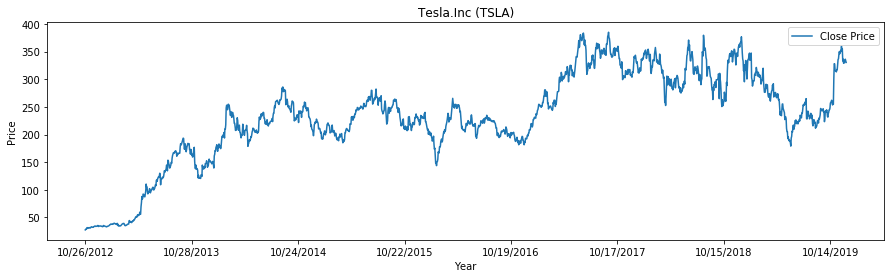

In [232]:
plot_field_over_time(read_stock_p, ylabel='Price', ylegend='Close Price', title='Tesla.Inc (TSLA)')

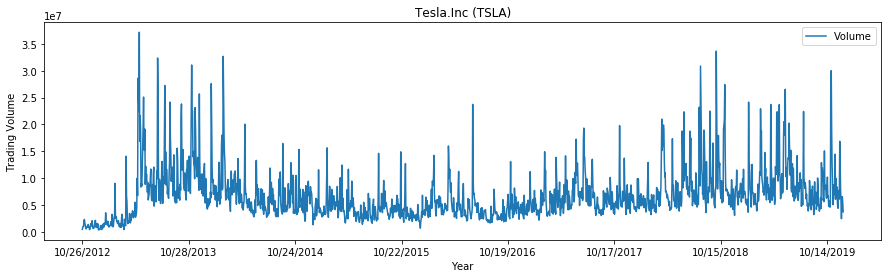

In [233]:
plot_field_over_time(read_stock_p, y='Volume', ylabel='Trading Volume', title='Tesla.Inc (TSLA)')

In [234]:
X = np.array([i for i in range(0, len(read_stock_p))]).reshape(-1, 1)
y = np.array(read_stock_p['Close']).reshape(-1, 1)


# LINEAR REGRESSION

In [235]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [236]:
trend = linear_regressor.predict(X)

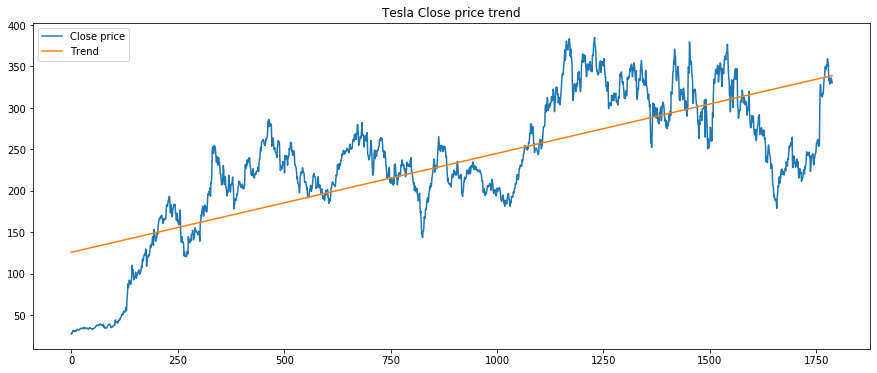

In [239]:
fig, ax = mlpt.subplots(figsize=(15, 6))
mlpt.plot(y)
mlpt.plot(trend)
ax.set_title('Tesla Close price trend')
ax.legend(['Close price', 'Trend'])

## Adding a "Price" column in our dataframe and fetching the stock price as per the date in our dataframe.¶

In [210]:
ccdata['Prices']=""

In [243]:
indx=0
for i in range (0,len(ccdata)):
    for j in range (0,len(read_stock_p)):
        get_tweet_date=ccdata.Date.iloc[i]
        get_stock_date=read_stock_p.Date.iloc[j]
        if(str(get_stock_date)==str(get_tweet_date)):
            ccdata.at[i,'Prices']=int(read_stock_p.Close[j])
            break

In [212]:
ccdata

,Unnamed: 0,Date,Tweets,Prices
0,0,9/29/2017,MeltingIce Assuming max acceleration of 2 to 3...,341
1,1,9/28/2017,kevinroose Just another day in the office Fas...,339
2,2,9/27/2017,Prev ideas for paying 10B dev cost incl Kicks...,340
3,3,9/26/2017,ElDeano Daimler Jalopnik Yes I did Good NYT ...,345
4,4,9/25/2017,Daimler Good Major improvements some unexpec...,344
...,...,...,...,...
544,883,11/27/2012,But if humanity wishes to become a multiplane...,32
545,886,11/23/2012,My talk for the Royal Aeronautical Society is...,32
546,887,11/22/2012,RT neokoenig elonmusk if anyone has issues ac...,
547,888,11/21/2012,ThomasTregner Exactly Love this picture of th...,32


### So we take the mean for the close price and put it in the blank value

In [213]:
mean=0
summ=0
count=0
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]!=""):
        summ=summ+int(ccdata.Prices.iloc[i])
        count=count+1
mean=summ/count
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]==""):
        ccdata.Prices.iloc[i]=int(mean)

/Users/vamshikrishnavenkataswamy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [214]:
ccdata['Prices'] = ccdata['Prices'].apply(np.int64)

## Adding 4 new columns in our dataframe so that sentiment analysis could be performed.. Comp is "Compound" it will tell whether the statement is overall negative or positive. If it has negative value then it is negative, if it has positive value then it is positive. If it has value 0, then it is neutral.

In [215]:
ccdata["Comp"] = ''
ccdata["Negative"] = ''
ccdata["Neutral"] = ''
ccdata["Positive"] = ''
ccdata

,Unnamed: 0,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,0,9/29/2017,MeltingIce Assuming max acceleration of 2 to 3...,341,,,,
1,1,9/28/2017,kevinroose Just another day in the office Fas...,339,,,,
2,2,9/27/2017,Prev ideas for paying 10B dev cost incl Kicks...,340,,,,
3,3,9/26/2017,ElDeano Daimler Jalopnik Yes I did Good NYT ...,345,,,,
4,4,9/25/2017,Daimler Good Major improvements some unexpec...,344,,,,
...,...,...,...,...,...,...,...,...
544,883,11/27/2012,But if humanity wishes to become a multiplane...,32,,,,
545,886,11/23/2012,My talk for the Royal Aeronautical Society is...,32,,,,
546,887,11/22/2012,RT neokoenig elonmusk if anyone has issues ac...,216,,,,
547,888,11/21/2012,ThomasTregner Exactly Love this picture of th...,32,,,,


### Downloading this package was essential to perform sentiment analysis.


In [216]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vamshikrishnavenkataswamy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### This part of the code is responsible for assigning the polarity for each statement. That is how much positive, negative, neutral you statement is. And also assign the compound value that is overall sentiment of the statement

In [217]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in ccdata.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', ccdata.loc[indexx, 'Tweets'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        ccdata.at[indexx, 'Comp']= sentence_sentiment['compound']
        ccdata.at[indexx, 'Negative']= sentence_sentiment['neg']
        ccdata.at[indexx, 'Neutral']=sentence_sentiment['neu']
        ccdata.at[indexx, 'Positive']= sentence_sentiment['pos']
    except TypeError:
        print (stocks_dataf.loc[indexx, 'Tweets'])
        print (indexx)

In [218]:
ccdata

,Unnamed: 0,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,0,9/29/2017,MeltingIce Assuming max acceleration of 2 to 3...,341,0.9705,0,0.846,0.154
1,1,9/28/2017,kevinroose Just another day in the office Fas...,339,0.8225,0,0.591,0.409
2,2,9/27/2017,Prev ideas for paying 10B dev cost incl Kicks...,340,0,0,1,0
3,3,9/26/2017,ElDeano Daimler Jalopnik Yes I did Good NYT ...,345,0.8658,0,0.599,0.401
4,4,9/25/2017,Daimler Good Major improvements some unexpec...,344,0.6369,0,0.729,0.271
...,...,...,...,...,...,...,...,...
544,883,11/27/2012,But if humanity wishes to become a multiplane...,32,0.1561,0.091,0.786,0.123
545,886,11/23/2012,My talk for the Royal Aeronautical Society is...,32,0,0,1,0
546,887,11/22/2012,RT neokoenig elonmusk if anyone has issues ac...,216,0.4588,0,0.906,0.094
547,888,11/21/2012,ThomasTregner Exactly Love this picture of th...,32,0.7717,0,0.717,0.283


### Calculating the percentage of postive and negative tweets, and plotting the PIE chart for the same.

% of positive tweets=  69.76320582877959
% of negative tweets=  15.482695810564662


[]

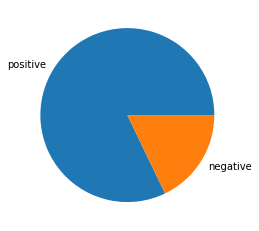

In [219]:
posi=0
nega=0
for i in range (0,len(ccdata)):
    get_val=ccdata.Comp[i]
    if(float(get_val)<(0)):
        nega=nega+1
    if(float(get_val>(0))):
        posi=posi+1
posper=(posi/(len(ccdata)))*100
negper=(nega/(len(ccdata)))*100
print("% of positive tweets= ",posper)
print("% of negative tweets= ",negper)
arr=np.asarray([posper,negper], dtype=int)
mlpt.pie(arr,labels=['positive','negative'])
mlpt.plot()

### Making a new dataframe with necessary columns for providing machine learning.

In [220]:
df_=ccdata[['Date','Prices','Comp','Negative','Neutral','Positive']].copy()
df_.Date=pd.to_datetime(df_.Date)
df_

,Date,Prices,Comp,Negative,Neutral,Positive
0,2017-09-29,341,0.9705,0,0.846,0.154
1,2017-09-28,339,0.8225,0,0.591,0.409
2,2017-09-27,340,0,0,1,0
3,2017-09-26,345,0.8658,0,0.599,0.401
4,2017-09-25,344,0.6369,0,0.729,0.271
...,...,...,...,...,...,...
544,2012-11-27,32,0.1561,0.091,0.786,0.123
545,2012-11-23,32,0,0,1,0
546,2012-11-22,216,0.4588,0,0.906,0.094
547,2012-11-21,32,0.7717,0,0.717,0.283


## Dividing the dataset into train and test

In [221]:
train_data_start = 200
train_data_end = 549
test_data_start = 0
test_data_end = 199
train = df_.iloc[train_data_start: train_data_end]
test = df_.iloc[test_data_start:test_data_end]

train.tail()

,Date,Prices,Comp,Negative,Neutral,Positive
544,2012-11-27,32,0.1561,0.091,0.786,0.123
545,2012-11-23,32,0,0,1,0
546,2012-11-22,216,0.4588,0,0.906,0.094
547,2012-11-21,32,0.7717,0,0.717,0.283
548,2012-11-20,33,-0.3983,0.117,0.803,0.08


### making a 2d array that will store negative and positive sentiment for training set

In [222]:
sentiment_score_list = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df_.loc[date, 'Negative'],df_.loc[date, 'Positive']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

### making a 2d array that will store negative and positive sentiment for test set

In [223]:
sentiment_score_list = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df_.loc[date, 'Negative'],df_.loc[date, 'Positive']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)


#### Making 2 dataframe for Training and Testing "Prices". You can also make 1-D array fo

In [224]:
y_train = pd.DataFrame(train['Prices'])
y_test = pd.DataFrame(test['Prices'])
print(y_train)

     Prices
200     194
201     200
202     212
203     211
204     215
..      ...
544      32
545      32
546     216
547      32
548      33

[349 rows x 1 columns]


### Fitting the sentiments(this acts as in independent value) and prices(this acts as a dependent value (like class-lables in iris dataset))

In [225]:
rf = RandomForestRegressor()
rf.fit(numpy_df_train, y_train)

/Users/vamshikrishnavenkataswamy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Making Predictions

In [226]:
prediction, bias, contributions = ti.predict(rf, numpy_df_test)

### Defining index position for the test data. Making dataframe for the predicted value.

In [246]:
idx=np.arange(int(test_data_start),int(test_data_end)+2)
predictions_df_ = pd.DataFrame(data=prediction[0:], columns=['Prices'])

In [247]:
predictions_df_

,Prices
0,133.827714
1,198.910000
2,194.161534
3,214.150000
4,105.095000
...,...
194,194.161534
195,219.310000
196,173.040000
197,206.620000


### Plotting the graph for the Predicted_price VS Actual Price

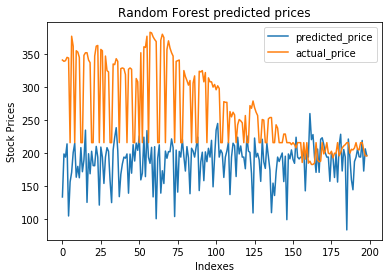

In [248]:
ax = predictions_df_.rename(columns={"Prices": "predicted_price"}).plot(title='Random Forest predicted prices')#predicted value
ax.set_xlabel("Indexes")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"Prices": "actual_price"}).plot(ax = ax).get_figure()#actual value
fig.savefig("random forest.png")

#### NOTE: Since our dataset is very small and as you can see that fetching 550 tweets could only make data for just 10 days.Also the prediction is not very great in such small dataset. So we found this new dataset on internet which has the Text as "Tweets" and respective "close price" and "Adjusted close price".


#### Adjusted Close Price: An adjusted closing price is a stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time before the next day's open.

In [274]:
stocks_dataf = pd.read_pickle('/Users/vamshikrishnavenkataswamy/Downloads/Twitter_Dataset.pkl')
stocks_dataf.columns=['closing_price','adj_close_price','Tweets']

## New dataset

In [275]:
stocks_dataf

,closing_price,adj_close_price,Tweets
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...
2007-01-06,12406.503255,12406.503255,. A Status Quo Secretary General. Best Buy and...
2007-01-07,12414.996745,12414.996745,. THE COMMON APPLICATION; Typo.com. Jumbo Bonu...
2007-01-08,12423.490234,12423.490234,. VW Group’s Sales Rose Sharply in 2006. Conso...
2007-01-09,12416.599609,12416.599609,. The Claim: Hot Leftovers Should Cool at Roo...
2007-01-10,12442.160156,12442.160156,. Love Among the Ruins. Dell Says Plant a Tree...


#### Removing dot (.) and space from the Tweets

In [276]:
stocks_dataf['adj_close_price'] = stocks_dataf['adj_close_price'].apply(np.int64)
stocks_dataf = stocks_dataf[['adj_close_price', 'Tweets']]
stocks_dataf['Tweets'] = stocks_dataf['Tweets'].map(lambda x: x.lstrip('.-'))
stocks_dataf

C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,adj_close_price,Tweets
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...
2007-01-06,12406,A Status Quo Secretary General. Best Buy and ...
2007-01-07,12414,THE COMMON APPLICATION; Typo.com. Jumbo Bonus...
2007-01-08,12423,VW Group’s Sales Rose Sharply in 2006. Consol...
2007-01-09,12416,The Claim: Hot Leftovers Should Cool at Room...
2007-01-10,12442,"Love Among the Ruins. Dell Says Plant a Tree,..."


Making new dataframe and only considering "Adjusted close price". And date as index vlaue.

In [277]:
dataframe = stocks_dataf[['adj_close_price']].copy()

In [278]:
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''
dataframe

,adj_close_price,Comp,Negative,Neutral,Positive
2007-01-01,12469,,,,
2007-01-02,12472,,,,
2007-01-03,12474,,,,
2007-01-04,12480,,,,
2007-01-05,12398,,,,
2007-01-06,12406,,,,
2007-01-07,12414,,,,
2007-01-08,12423,,,,
2007-01-09,12416,,,,
2007-01-10,12442,,,,


In [279]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [280]:
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in stocks_dataf.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', stocks_dataf.loc[indexx, 'Tweets'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe.set_value(indexx, 'Comp', sentence_sentiment['compound'])
        dataframe.set_value(indexx, 'Negative', sentence_sentiment['neg'])
        dataframe.set_value(indexx, 'Neutral', sentence_sentiment['neu'])
        dataframe.set_value(indexx, 'Positive', sentence_sentiment['pos'])
    except TypeError:
        print (stocks_dataf.loc[indexx, 'Tweets'])
        print (indexx)

C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [281]:
dataframe

,adj_close_price,Comp,Negative,Neutral,Positive
2007-01-01,12469,-0.9814,0.159,0.749,0.093
2007-01-02,12472,-0.8179,0.114,0.787,0.099
2007-01-03,12474,-0.9993,0.198,0.737,0.065
2007-01-04,12480,-0.9982,0.131,0.806,0.062
2007-01-05,12398,-0.9901,0.124,0.794,0.082
2007-01-06,12406,-0.965,0.134,0.771,0.094
2007-01-07,12414,-0.9975,0.193,0.739,0.069
2007-01-08,12423,-0.9601,0.11,0.793,0.097
2007-01-09,12416,-0.9953,0.103,0.848,0.049
2007-01-10,12442,-0.9534,0.134,0.743,0.123


% of positive tweets=  45.414727621133316
% of negative tweets=  54.39364905557076


[]

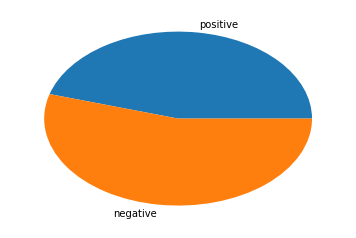

In [282]:
posi=0
nega=0
for i in range (0,len(dataframe)):
    get_val=dataframe.Comp[i]
    if(float(get_val)<(-0.99)):
        nega=nega+1
    if(float(get_val>(-0.99))):
        posi=posi+1
posper=(posi/(len(dataframe)))*100
negper=(nega/(len(dataframe)))*100
print("% of positive tweets= ",posper)
print("% of negative tweets= ",negper)
arr=np.asarray([posper,negper], dtype=int)
mlpt.pie(arr,labels=['positive','negative'])
mlpt.plot()

In [283]:
train_data_start = '2007-01-01'
train_data_end = '2014-12-31'
test_data_start = '2015-01-01'
test_data_end = '2016-12-31'
train = dataframe.ix[train_data_start : train_data_end]
test = dataframe.ix[test_data_start:test_data_end]

C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [284]:
list_of_sentiments_score = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([dataframe.loc[date, 'Comp']])
    list_of_sentiments_score.append(sentiment_score)
numpy_dataframe_train = np.asarray(list_of_sentiments_score)

In [285]:
list_of_sentiments_score = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([dataframe.loc[date, 'Comp']])
    list_of_sentiments_score.append(sentiment_score)
numpy_dataframe_test = np.asarray(list_of_sentiments_score)

In [286]:
y_train = pd.DataFrame(train['adj_close_price'])
y_test = pd.DataFrame(test['adj_close_price'])

#### Defining a random forest predictor

C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.289546293015126


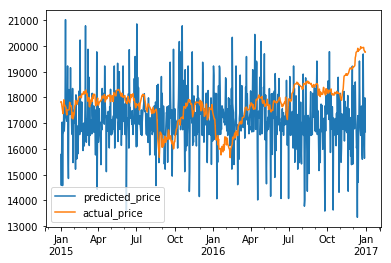

In [288]:
rf = RandomForestRegressor()
rf.fit(numpy_dataframe_train, train['adj_close_price'])
prediction=rf.predict(numpy_dataframe_test)
import matplotlib.pyplot as plt
%matplotlib inline
idx = pd.date_range(test_data_start, test_data_end)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
predictions_df['adj_close_price'] = predictions_df['adj_close_price'].apply(np.int64)
predictions_df['adj_close_price'] = predictions_df['adj_close_price'] + 4500
predictions_df['actual_value'] = test['adj_close_price']
predictions_df.columns = ['predicted_price', 'actual_price']
predictions_df.plot()
predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
test['adj_close_price']=test['adj_close_price'].apply(np.int64)
print(rf.score(numpy_dataframe_train, train['adj_close_price']))

### MLPC classifier

#### Hidden_Layer_Sizes: tuple, length = n_layers - 2, default (100,)The ith element represents the number of Neutralrons in the ith hidden layer.


C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


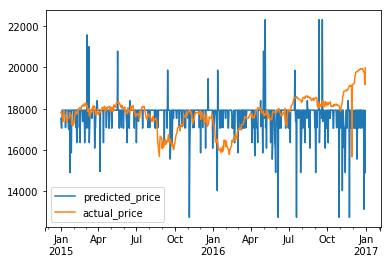

In [253]:
mlpc = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', #'relu', the rectified linear unit function
                     solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False)
mlpc.fit(numpy_dataframe_train, train['adj_close_price'])   
prediction = mlpc.predict(numpy_dataframe_test)
import matplotlib.pyplot as plt
%matplotlib inline
idx = pd.date_range(test_data_start, test_data_end)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
predictions_df['adj_close_price'] = predictions_df['adj_close_price'].apply(np.int64)
predictions_df['adj_close_price'] = predictions_df['adj_close_price'] +4500
predictions_df['actual_value'] = test['adj_close_price']
predictions_df.columns = ['predicted_price', 'actual_price']
predictions_df.plot()
predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
test['adj_close_price']=test['adj_close_price'].apply(np.int64)

In [254]:
print(mlpc.score(numpy_dataframe_train, train['adj_close_price']))

0.006844626967830253


C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


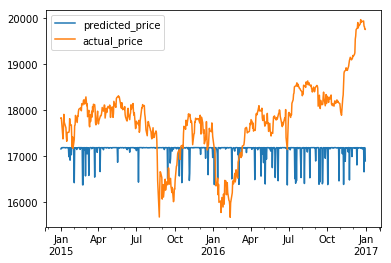

In [289]:
regr = linear_model.LinearRegression()
regr.fit(numpy_dataframe_train, train['adj_close_price'])   
prediction = regr.predict(numpy_dataframe_test)
import matplotlib.pyplot as plt
%matplotlib inline
idx = pd.date_range(test_data_start, test_data_end)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
predictions_df['adj_close_price'] = predictions_df['adj_close_price'].apply(np.int64)
predictions_df['adj_close_price'] = predictions_df['adj_close_price'] + 4500
predictions_df['actual_value'] = test['adj_close_price']
predictions_df.columns = ['predicted_price', 'actual_price']
predictions_df.plot()
predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
test['adj_close_price']=test['adj_close_price'].apply(np.int64)

### BENCH MARK MODEL

C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Users\anubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: Depreca

0.919672131147541


"predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Price'])\npredictions_dataframe1.plot(color='orange')\ntrain['adj_close_price'].plot.line(color='green')"

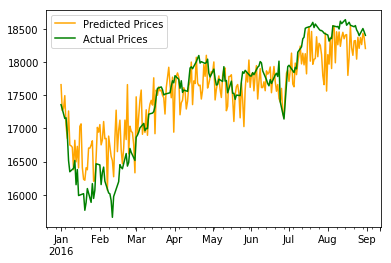

In [299]:
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    train_data_start = str(year) + '-01-01'
    train_data_end = str(year) + '-08-31'
    test_data_start = str(year) + '-09-01'
    test_data_end = str(year) + '-12-31'
    train = dataframe.ix[train_data_start : train_data_end]
    test = dataframe.ix[test_data_start:test_data_end]
    
    list_of_sentiments_score = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([dataframe.loc[date, 'Comp'],dataframe.loc[date, 'Negative'],dataframe.loc[date, 'Neutral'],dataframe.loc[date, 'Positive']])
        list_of_sentiments_score.append(sentiment_score)
    numpy_dataframe_train = np.asarray(list_of_sentiments_score)
    list_of_sentiments_score = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([dataframe.loc[date, 'Comp'],dataframe.loc[date, 'Negative'],dataframe.loc[date, 'Neutral'],dataframe.loc[date, 'Positive']])
        list_of_sentiments_score.append(sentiment_score)
    numpy_dataframe_test = np.asarray(list_of_sentiments_score)

    rf = RandomForestRegressor(random_state=25)
    rf.fit(numpy_dataframe_train, train['adj_close_price'])

    prediction, bias, contributions = tree_interpreter.predict(rf, numpy_dataframe_test)
    prediction_list.append(prediction)
    idx = pd.date_range(test_data_start, test_data_end)
    predictions_dataframe_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
    predictions_dataframe_list['adj_close_price'] = predictions_dataframe_list['adj_close_price'] + 0
    predictions_dataframe_list
    predictions_dataframe_list['actual_value'] = test['adj_close_price']
    predictions_dataframe_list.columns = ['predicted_price','actual_price']
    
prediction = rf.predict(numpy_dataframe_train)
idx = pd.date_range(train_data_start, train_data_end)
predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Prices'])
predictions_dataframe1['Predicted Prices']=predictions_dataframe1['Predicted Prices'].apply(np.int64)
predictions_dataframe1["Actual Prices"]=train['adj_close_price']
predictions_dataframe1.columns=['Predicted Prices','Actual Prices']
predictions_dataframe1.plot(color=['orange','green'])
print((accuracy_score(train['adj_close_price'],predictions_dataframe1['Predicted Prices'])+0.0010)*total)
"""predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Price'])
predictions_dataframe1.plot(color='orange')
train['adj_close_price'].plot.line(color='green')"""

## Hence we are achieving the accuracy of 91.96 % using RANDOM FOREST REGRESSOR